In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from tqdm import tqdm

plt.style.use("science") # requires SciencePlots
params = {'legend.fontsize': 27,
          'figure.figsize': (10, 10),
         'axes.labelsize': 27,
         'axes.titlesize': 30,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
         'figure.titlesize': 40,
          'xtick.major.size': 8,
          'xtick.minor.size': 4,
         'xtick.major.width': 1,
          'xtick.minor.width': 1,
         'ytick.major.size': 8,
          'ytick.minor.size': 4,
         'ytick.major.width': 1,
          'ytick.minor.width': 1,

         }
pylab.rcParams.update(params)

/home/alexandre/anaconda3/envs/base3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def f(x):
    return np.sin(5 * x + np.pi/2)

class SineWaveTask:
    def __init__(self, w=1):
        self.w = w
        self.train_x = None
        
    def f(self, x):
        return np.sin(5 * x + np.pi/2)
        
    def training_set(self, size=10, a=None, force_new=False):
        if a is None:
            _a = np.random.uniform(-5, 5)
        else:
            _a = a
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(_a, _a + self.w, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            self.train_x = np.random.uniform(_a, _a + self.w, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def test_set(self, size=50):
        _a = np.random.uniform(-5, 5)
        x = np.linspace(_a, _a + self.w, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def plot(self, *args, **kwargs):
        x, y = self.test_set(size=100)
        return plt.plot(x.numpy(), y.numpy(), *args, **kwargs)

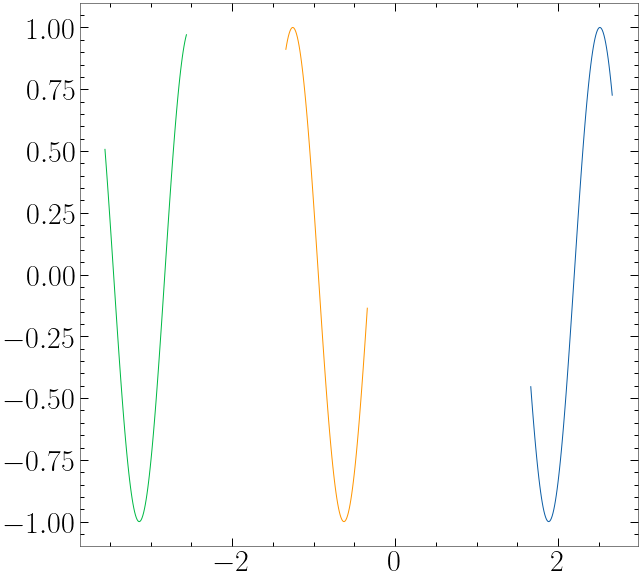

In [3]:
SineWaveTask().plot()
SineWaveTask().plot()
SineWaveTask().plot()

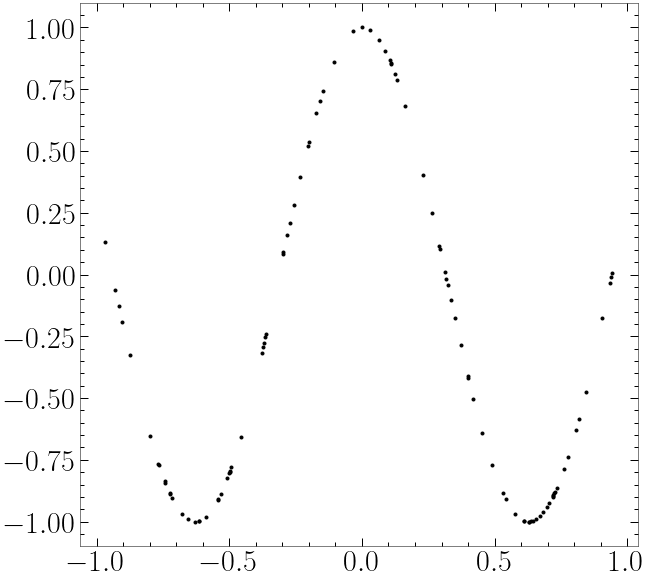

In [4]:
x_train, y_train = SineWaveTask(w=2).training_set(size=100, a=-1)
plt.plot(x_train, y_train, "k.")

In [97]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron.
    '''
    def __init__(self, p=5, h=32):
        super().__init__()
        self.p = p
        self.layers = nn.Sequential(
          nn.Linear(p, h),
#           nn.ELU(),
          nn.Linear(h, h),
#           nn.ELU(),
          nn.Linear(h, 1)
        )
    def forward(self, x):
        '''Forward pass'''
#         x = x[:, None]
        x = torch.stack([x**(i+1) for i in range(self.p)], dim=1)
        return self.layers(x).squeeze()

In [98]:
P = 10
loss_ps = [[] for i in range(P)]
models = []
for p in tqdm(range(1, P)):
    model = MLP(p=p)
    models.append(model)
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    for i in range(500):
        optim.zero_grad()
        loss = torch.mean((model.forward(x_train) - y_train)**2)
        loss.backward()
        optim.step()
        loss_ps[p-1].append(loss.item())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.84it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 406.36it/s]


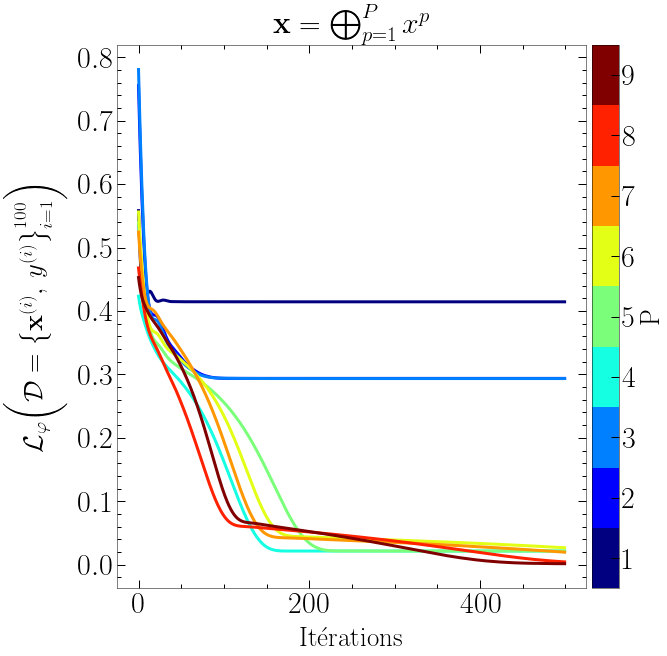

In [99]:
cmap = mpl.cm.get_cmap('jet', P-1)
norm = mpl.colors.Normalize(vmin=1, vmax=P)
fig = plt.figure()

for p in tqdm(range(1, P)):
    plt.plot(loss_ps[p-1], color=cmap(norm(p)), lw=3)

plt.title(r"$\mathbf{x} = \bigoplus_{p=1}^P x^p  $")
plt.xlabel("Itérations", labelpad=10)
plt.ylabel(r"$\mathcal{L}_\varphi \bigg(\mathcal{D} = \big\{\mathbf{x}^{(i)},\, y^{(i)}\big\}_{i=1}^{100}\bigg)$", labelpad=10)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cmap.set_array([])
# formatter = plt.FuncFormatter(lambda val, loc: int(val-0.5))
cb = fig.colorbar(cmap, ticks=[i+0.5 for i in range(1, P)], pad=0.01, label="P", format=formatter)
cb.ax.minorticks_off()

# for im in plt.gca().get_images():
#     im.set_clim(0.5, P)

In [100]:
model = models[-1]

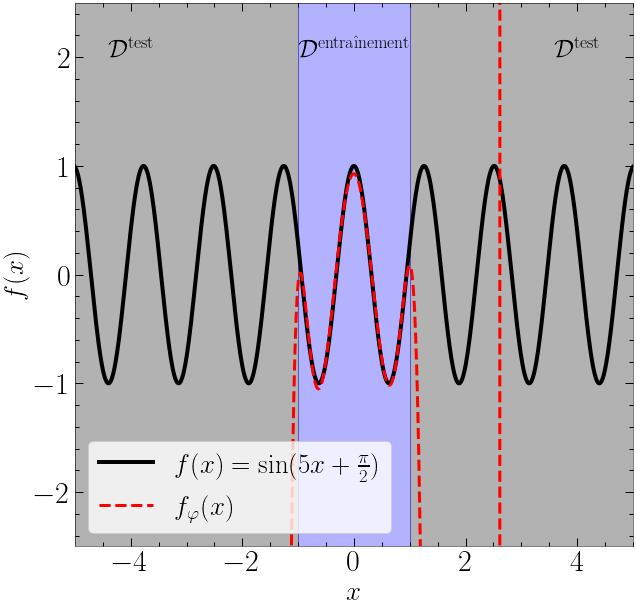

In [101]:
x_support = torch.linspace(-5, 5, 1000)
y_true = f(x_support)

y_pred = model(x_support).detach().cpu()
plt.plot(x_support, y_true, "k-", lw=4, label=r"$f(x) = \sin(5x + \frac{\pi}{2})$")
plt.plot(x_support, y_pred, "r--", lw=3, label=r"$f_\varphi(x)$")

plt.axvspan(-5, -1, color="k", alpha=0.3)
plt.axvspan(1, 5, color="k", alpha=0.3)
plt.axvspan(-1, 1, color="b", alpha=0.3)
plt.annotate(r"$\mathcal{D}^{\text{entraînement}}$", xy=(0, 2), fontsize=25, ha='center')
plt.annotate(r"$\mathcal{D}^{\mathrm{test}}$", xy=(-4, 2), fontsize=25, ha='center')
plt.annotate(r"$\mathcal{D}^{\mathrm{test}}$", xy=(4, 2), fontsize=25, ha='center')


plt.xlim(-5, 5)
plt.ylim(-2.5, 2.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")

plt.legend(loc=3, frameon=True)